In [1]:
import pandas as pd

# Load the CSV file
file_path = r"D:\coursework\Main Project\mimic-iv-2.2\mimic-iv-2.2\omr.csv"
df = pd.read_csv(file_path)

# Pivot the DataFrame ensuring that we take the latest entry in case of multiple values for the same subject and measurement
pivot_df_latest = df.pivot_table(index='subject_id', columns='result_name', values='result_value', aggfunc='last').reset_index()

# Rename columns for clarity
pivot_df_latest.columns.name = None
pivot_df_latest.columns = ['subject_id'] + list(pivot_df_latest.columns[1:])

# Display the transformed DataFrame
print(pivot_df_latest.head())

   subject_id  BMI BMI (kg/m2) Blood Pressure Blood Pressure Lying  \
0    10000032  NaN        18.2          98/66                  NaN   
1    10000084  NaN        24.4            NaN                  NaN   
2    10000117  NaN        18.9         108/74                  NaN   
3    10000248  NaN        25.5            NaN                  NaN   
4    10000280  NaN         NaN         125/77                  NaN   

  Blood Pressure Sitting Blood Pressure Standing  \
0                    NaN                     NaN   
1                    NaN                     NaN   
2                    NaN                     NaN   
3                    NaN                     NaN   
4                    NaN                     NaN   

  Blood Pressure Standing (1 min) Blood Pressure Standing (3 mins) Height  \
0                             NaN                              NaN    NaN   
1                             NaN                              NaN    NaN   
2                             NaN  

In [2]:
# Optionally, save the transformed DataFrame to a new CSV file
pivot_df_latest.to_csv(r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\transformed_omr_full_data.csv', index=False)


In [3]:
import pandas as pd

# Load the data from the provided CSV file
file_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\transformed_omr_full_data.csv'
data = pd.read_csv(file_path)

# Drop the specified columns
columns_to_drop = ['BMI', 'Blood Pressure Lying', 'Blood Pressure Sitting', 'Blood Pressure Standing','Blood Pressure Standing (1 min)','Blood Pressure Standing (3 mins)','Height','Weight','eGFR']
data_cleaned = data.drop(columns=columns_to_drop)

# Save the cleaned data to a new CSV file
cleaned_file_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\cleaned_transformed_omr_full_data.csv'
data_cleaned.to_csv(cleaned_file_path, index=False)

# Display the first few rows of the cleaned data to verify the changes
print(data_cleaned.head())


   subject_id  BMI (kg/m2) Blood Pressure  Height (Inches)  Weight (Lbs)
0    10000032         18.2          98/66             60.0         93.03
1    10000084         24.4            NaN             70.0        170.00
2    10000117         18.9         108/74             64.0        110.00
3    10000248         25.5            NaN             68.0        168.00
4    10000280          NaN         125/77              NaN        170.50


In [4]:
# Load the dataset
file_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\cleaned_transformed_omr_full_data.csv'
df = pd.read_csv(file_path)

# Convert weight from Lbs to Kg and height from Inches to Cms, rounding to 2 decimal places
df['Weight (Kg)'] = (df['Weight (Lbs)'] * 0.453592).round(2)
df['Height (Cm)'] = (df['Height (Inches)'] * 2.54).round(2)

# Save the updated dataframe to the same CSV file
df.to_csv(file_path, index=False)

# Display the first few rows of the updated dataframe
df.head()


,subject_id,BMI (kg/m2),Blood Pressure,Height (Inches),Weight (Lbs),Weight (Kg),Height (Cm)
0,10000032,18.2,98/66,60.0,93.03,42.20,152.40
1,10000084,24.4,NaN,70.0,170.00,77.11,177.80
2,10000117,18.9,108/74,64.0,110.00,49.90,162.56
3,10000248,25.5,NaN,68.0,168.00,76.20,172.72
4,10000280,NaN,125/77,NaN,170.50,77.34,NaN


In [5]:
columns_to_drop = ['Height (Inches)','Weight (Lbs)']
df = df.drop(columns=columns_to_drop)

df.to_csv(file_path, index=False)

In [6]:
df.head()

,subject_id,BMI (kg/m2),Blood Pressure,Weight (Kg),Height (Cm)
0,10000032,18.2,98/66,42.20,152.40
1,10000084,24.4,NaN,77.11,177.80
2,10000117,18.9,108/74,49.90,162.56
3,10000248,25.5,NaN,76.20,172.72
4,10000280,NaN,125/77,77.34,NaN


In [7]:
# Find missing values
missing_values = df.isnull().sum()

# Display missing values
print(missing_values)

subject_id            0
BMI (kg/m2)       20680
Blood Pressure    22722
Weight (Kg)        8439
Height (Cm)       25372
dtype: int64


In [8]:
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Load the transformed data
file_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\cleaned_transformed_omr_full_data.csv'
df = pd.read_csv(file_path)

# Preprocess to handle null values - Imputation example using median for numerical columns
numerical_columns = ['Weight (Kg)', 'Height (Cm)']  # Assuming BMI is to be recalculated and thus not imputed
for col in numerical_columns:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Check and fill categorical data with the mode
categorical_columns = ['Blood Pressure']
for col in categorical_columns:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

# Slice the DataFrame to get only the first 1000 entries
df_subset = df.head(1000)  # or df.iloc[:1000]

# Define the metadata for the dataset, excluding 'BMI (kg/m2)' since it will be recalculated
metadata = SingleTableMetadata()

# Add columns to metadata
metadata.add_column('subject_id', sdtype='id')
metadata.add_column('BMI (kg/m2)', sdtype='numerical')
metadata.add_column('Blood Pressure', sdtype='categorical')
metadata.add_column('Weight (Kg)', sdtype='numerical')
metadata.add_column('Height (Cm)', sdtype='numerical')

# Initialize the CTGAN model
ctgan = CTGANSynthesizer(metadata)

# Train the model using only the subset of data
ctgan.fit(df_subset)

# Generate synthetic data
synthetic_data = ctgan.sample(1000)  # Adjust the number of samples as needed

# Post-generation: Calculate BMI
synthetic_data['BMI (kg/m2)'] = (synthetic_data['Weight (Kg)'] / (synthetic_data['Height (Cm)'] / 100) ** 2).round(2)

# Display the first few rows of the synthetic data
print(synthetic_data.head())

# Optionally, save the synthetic data to a new CSV file
save_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\synthetic_omr.csv'
synthetic_data.to_csv(save_path, index=False)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34724\4016502772.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34724\4016502772.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

   subject_id  BMI (kg/m2) Blood Pressure  Weight (Kg)  Height (Cm)
0   687749426        34.29         134/69        93.72       165.33
1    29880573        30.33         110/66        77.83       160.18
2    32829814        34.90         139/82        77.28       148.81
3   809018963        35.79         104/70        77.40       147.06
4   881725845        30.36         112/72        88.98       171.20


In [9]:
import pandas as pd
import random

# Load the synthetic data
file_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\synthetic_omr.csv'
synthetic_data = pd.read_csv(file_path)

def assign_blood_pressure(row):
    # Define the ranges and their corresponding probabilities
    ranges = {
        "90-120/60-80": 0.70,
        "120-140/80-90": 0.10,
        "140-160/90-100": 0.10,
        "70-90/40-60": 0.05,
        "160-185/100-125": 0.05
    }
    
    # Choose a range based on the specified probabilities
    chosen_range = random.choices(
        population=list(ranges.keys()),
        weights=list(ranges.values()),
        k=1
    )[0]
    
    # Generate a random blood pressure value within the chosen range
    if chosen_range == "90-120/60-80":
        systolic = random.randint(90, 120)
        diastolic = random.randint(60, 80)
    elif chosen_range == "120-140/80-90":
        systolic = random.randint(120, 140)
        diastolic = random.randint(80, 90)
    elif chosen_range == "140-160/90-100":
        systolic = random.randint(140, 160)
        diastolic = random.randint(90, 100)
    elif chosen_range == "70-90/40-60":
        systolic = random.randint(70, 90)
        diastolic = random.randint(40, 60)
    elif chosen_range == "160-185/100-125":
        systolic = random.randint(160, 185)
        diastolic = random.randint(100, 125)
    
    return f"{systolic}/{diastolic}"

# Apply the function to adjust blood pressure values
synthetic_data['Blood Pressure'] = synthetic_data.apply(assign_blood_pressure, axis=1)

# Display the first few rows of the adjusted synthetic data
print(synthetic_data.head())

# Save the updated synthetic data to the same CSV file
synthetic_data.to_csv(file_path, index=False)

print("Updated synthetic data saved successfully in the same file.")


   subject_id  BMI (kg/m2) Blood Pressure  Weight (Kg)  Height (Cm)
0   687749426        34.29         106/74        93.72       165.33
1    29880573        30.33          92/79        77.83       160.18
2    32829814        34.90         118/60        77.28       148.81
3   809018963        35.79         126/88        77.40       147.06
4   881725845        30.36         134/88        88.98       171.20
Updated synthetic data saved successfully in the same file.


In [10]:
real_data_path = r"C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\cleaned_transformed_omr_full_data.csv"
synthetic_data_path = r"C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\synthetic_omr.csv"

real_df = pd.read_csv(real_data_path)
synthetic_df = pd.read_csv(synthetic_data_path)


In [11]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_df,
    synthetic_data=synthetic_df,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████████████████████████████████████████████████| 5/5 [00:00<00:00, 146.55it/s]|
Data Validity Score: 97.82%

(2/2) Evaluating Data Structure: |█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.07it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 98.91%



In [12]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_df,
    synthetic_df,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]|
Column Shapes Score: 67.06%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]|
Column Pair Trends Score: 39.42%

Overall Score (Average): 53.24%



In [13]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,BMI (kg/m2),KSComplement,0.775322
1,Blood Pressure,TVComplement,0.226713
2,Weight (Kg),KSComplement,0.776306
3,Height (Cm),KSComplement,0.904172


In [14]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_df,
    synthetic_data=synthetic_df,
    column_name='Blood Pressure',
    metadata=metadata
)

fig.show()

In [21]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df_subset,
    synthetic_data=synthetic_df,
    column_name='Weight (Kg)',
    metadata=metadata
)

fig.show()

In [22]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df_subset,
    synthetic_data=synthetic_df,
    column_name='BMI (kg/m2)',
    metadata=metadata
)

fig.show()

In [23]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df_subset,
    synthetic_data=synthetic_df,
    column_name='Height (Cm)',
    metadata=metadata
)

fig.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the synthetic data
file_path = r'C:\Users\Lenovo\OneDrive - University of Leeds\Final Code\synthetic_omr.csv'
synthetic_data = pd.read_csv(file_path)

# Function to classify blood pressure readings
def classify_blood_pressure(bp):
    systolic, diastolic = map(int, bp.split('/'))
    if 90 <= systolic <= 120 and 60 <= diastolic <= 80:
        return "90-120/60-80"
    elif 120 < systolic <= 140 and 80 < diastolic <= 90:
        return "120-140/80-90"
    elif 140 < systolic <= 160 and 90 < diastolic <= 100:
        return "140-160/90-100"
    elif 70 <= systolic < 90 and 40 <= diastolic < 60:
        return "70-90/40-60"
    elif 160 < systolic <= 185 and 100 < diastolic <= 125:
        return "160-185/100-125"
    else:
        return "Out of defined ranges"  # To handle cases that do not fit any defined category

# Apply the classification function to the blood pressure data
synthetic_data['BP Category'] = synthetic_data['Blood Pressure'].apply(classify_blood_pressure)

# Calculate the frequencies of each category
category_frequencies = synthetic_data['BP Category'].value_counts()

# Print the frequencies of each category
print(category_frequencies)


BP Category
90-120/60-80             705
140-160/90-100            87
120-140/80-90             84
160-185/100-125           52
70-90/40-60               44
Out of defined ranges     28
Name: count, dtype: int64


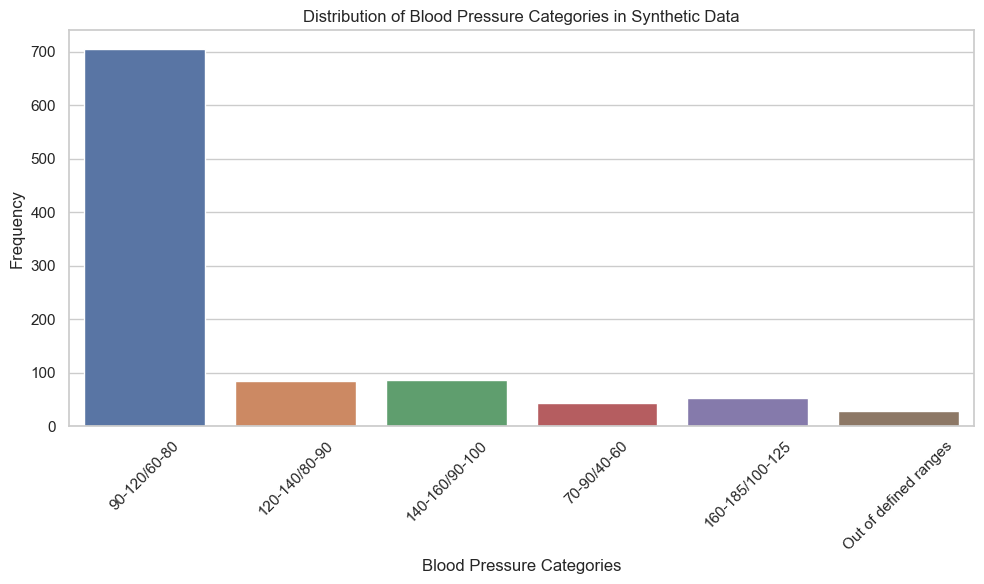

In [27]:
# Set up the aesthetics for seaborn plots
sns.set(style="whitegrid")

# Create a count plot for the Blood Pressure categories
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='BP Category', data=synthetic_data, order=[
    "90-120/60-80", "120-140/80-90", "140-160/90-100", "70-90/40-60", "160-185/100-125", "Out of defined ranges"
])
ax.set_title('Distribution of Blood Pressure Categories in Synthetic Data')
ax.set_xlabel('Blood Pressure Categories')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()